In [ ]:
from IPython.display import display, Math, Latex

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

###Polynomial Transformation

In [ ]:
import itertools
import functools

def get_combinations(x, degree):
  return itertools.combinations_with_replacement(x, degree)

def compute_new_features(items):
  return functools.reduce(lambda x, y: x * y, items)

In [ ]:
def polynomial_transformation(x, degree, logging=False):

  if x.ndim == 1:
    x = x[:, None]

  x_t = x.transpose()
  features = [np.ones(len(x))]

  if logging:
    print('Input: ', x)

  for d in range(1, degree+1):
    for items in get_combinations(x_t, d):
      features.append(compute_new_features(items))
      if logging:
        print(items, ':', compute_new_features(items))
    
  if logging:
    print(np.asarray(features).transpose())

  return np.asarray(features).transpose()    

###Label Encoding

In [ ]:
class LabelTranformer(object):
  '''
  Label encoder decoder

  Attributes:
  n_classes : int
            Number of classes, K

  '''

  def __init__(self, n_classes:int = None):
      self.n_classes = n_classes

  @property
  def n_classes(self):
    return self.__n_classes

  @n_classes.setter
  def n_classes(self, k):
    self.__n_classes = k
    self.__encoder = None if k is None else np.eye(k)

  @property
  def encoder(self):
    return self.__encoder

  def encode(self, class_indices:np.ndarray):
    '''
    encode class into one-of-k code

    parameters
    -----------
    class_indices : (N,) np.ndarray
        Non-Negative class index
        elements must be integer in [0, n_classes]

    Returns
    ----------
    (N,K) np.ndarray
        one-of-k encoding of input
    '''

    if self.n_classes is None:
      self.n_classes = np.max(class_indices) + 1  

    return self.encoder[class_indices]

  def decode(self, onehot:np.ndarray):

    return np.argmax(onehot, axis=1)

In [ ]:
binary_labels = LabelTranformer(2).encode(np.array([1, 0, 1, 0]))
binary_labels

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

###LSC implementation

In [ ]:
class LSC(object):
  """
  y = X@w
  X: A feature matrix
  w : weight vector
  y: label vector



  """
  def __init__(self):
    self.t0 = 20
    self.t1 = 100000

  def predict(self,X:np.ndarray):

    assert X.shape[-1] ==  self.w.shape[0], f'X shape {X.shape} and w shape{self.w.shape} are not compatible'
    
    return np.argmax(X @ self.w, axis=-1)

  def predict_internal(self, X:np.ndarray):

    return X @ self.w
  
  def loss(self, X:np.ndarray, y:np.ndarray):
    e =  self.predict_internal(X)-y
    return ((1/2)*(np.transpose(e) @ e))

  def rmse (self, X:np.ndarray, y:np.ndarray):
    return np.sqrt((2/X.shape[0]) * self.loss(X,y)) #2/n * loss
  
  def fit (self, X:np.ndarray, y:np.ndarray, reg_rate:float):
    
    self.w = np.zeros((X.shape[1]))
    eye = np.eye(np.size(X, 1))
    self.w = np.linalg.solve(
        reg_rate * eye + X.T @ X,
        X.T @ y
    )

    return self.w
  
  def calculate_gradient(self, X:np.ndarray, y:np.ndarray, reg_rate:float):
    return(np.transpose(X) @ (self.predict(X)-y) + reg_rate * self.w)
  
  def update_weights(self, grad:np.ndarray, lr:float):
    return(self.w - lr*grad)

  def learning_schedule(self,t):
    return self.t0 / (t+self.t1)

  def gd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, lr:float):
    self.w = np.zeros((X.shape[1]))
    self.w_all = []
    self.err_all = []
    for i in np.arange(0,num_epochs):
      self.w_all.append(self.w)
      self.err_all.append(self.loss(X,y))
      djdw = self.calculate_gradient(X,y)
      self.w = self.update_weights(djdw,lr)
    return self.w

  def mbgd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, batch_size:int):
    self.w = np.zeros((X.shape[1]))
    self.w_all = []
    self.err_all = []
    mini_batch_id = 0

    for epoch in range(num_epochs):
      shuffled_indices = np.random.permutation(X.shape[0])
      X_shuffled = X[shuffled_indices]
      y_shuffled = y[shuffled_indices]
      for i in range(0,X.shape[0],batch_size):
        mini_batch_id += 1
        xi = X_shuffled[i:i+batch_size]
        yi = y_shuffled[i:i+batch_size]
        self.w_all.append(self.w)
        self.err_all.append(self.loss(xi,yi))
        djdw = 2/batch_size * self.calculate_gradient(xi,yi)
        self.w = self.update_weights(djdw,self.learning_schedule(mini_batch_id))
    return self.w

  def sgd(self, X:np.ndarray, y:np.ndarray, num_epochs:int):
    self.w = np.zeros((X.shape[1]))
    self.w_all = []
    self.err_all = []
 
    for epoch in range(num_epochs):
      for i in range(X.shape[0]):
       
        random_index = np.random.randint(X.shape[0])
        xi = X[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        self.w_all.append(self.w)
        self.err_all.append(self.loss(xi,yi))
        djdw = 2 * self.calculate_gradient(xi,yi)
        self.w = self.update_weights(djdw,self.learning_schedule(epoch * X.shape[0] + i))
    return self.w





###Demonstartion

creating toy dataset 

In [ ]:
def create_toy_data(add_outliers=False, add_class=False):

  x0 = np.random.normal(size=50).reshape(-1, 2) - 1
  x1 = np.random.normal(size=50).reshape(-1, 2) + 1

  if add_outliers:
    x_1 = np.random.normal(size=10).reshape(-1, 2) + np.array([5., 10.])
    return np.concatenate([x0, x1, x_1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)

  if add_class:
    x2 = np.random.normal(size=50).reshape(-1, 2) + 2
    return np.concatenate([x0, x1, x2]), np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)

  return np.concatenate([x0, x1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)

In [ ]:
x = np.concatenate([np.zeros(25), np.ones(25)])
x

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
from sklearn.model_selection import train_test_split

def preprocessing(add_class=False, add_outliers=False, degree=1):

  x, y = create_toy_data(add_outliers, add_class)
  x_poly = polynomial_transformation(x, degree)

  x_train, x_test, y_train, y_test = train_test_split(x_poly, y)
  y_train_trans = LabelTranformer().encode(y_train)
  y_test_trans = LabelTranformer().encode(y_test)

  return x_train, x_test, y_train, y_test, y_train_trans, y_test_trans

In [ ]:
#visualization

'Some code'

'Some code'

In [ ]:
x_train, x_test, y_train, y_test, y_train_trans, y_test_trans = preprocessing()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)


(37, 3)
(37,)
(13, 3)
(13,)


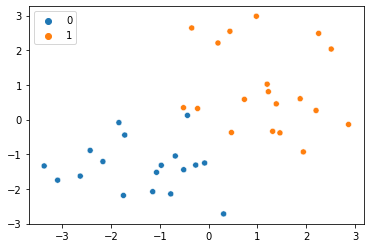

In [ ]:
sns.scatterplot(data=x_train, x=x_train[:, -2], y=x_train[:, -1], hue = y_train)

In [ ]:
lsc = LSC()

In [ ]:
w = lsc.fit(x_train, y_train_trans, reg_rate=0)
print('Weight', w)

Weight [[ 0.44374174  0.55625826]
 [-0.16659187  0.16659187]
 [-0.1586804   0.1586804 ]]


In [ ]:
#Evaluation

In [ ]:
y_hat = lsc.predict(x_test)
print(y_hat.shape)

(13,)


In [ ]:
tp = np.where((y_test == 1) & (y_hat == 1), 1, 0).sum()
tn = np.where((y_test == 0) & (y_hat == 0), 1, 0).sum()
fp = np.where((y_test == 0) & (y_hat == 1), 1, 0).sum()
fn = np.where((y_test == 1) & (y_hat == 0), 1, 0).sum()

In [ ]:
def precision(tp, fp):
  if tp+fp == 0: return np.NaN
  return tp/(tp+fp)

In [ ]:
def recall(tp, fn):
  if tp+fn == 0: return np.NaN
  return tp/(tp+fn)

In [ ]:
def accuracy(tp, fp, tn, fn):
 
  return (tp + tn)/(tp+fp+tn+fn)

In [ ]:
def f1_score(pr, r):
  
  return 2 * ((pr*r)/(pr+r))

In [ ]:
pr = precision(tp, fp)
r = recall(tp, fn)
print('precission', pr)
print('recall', r)
print('Accusracy', accuracy(tp, fp, tn, fn))
print('f1_score', f1_score(pr, r))

precission 1.0
recall 1.0
Accusracy 1.0
f1_score 1.0
